# Test if the model of PCA+SVM is robust in our data set

In [1]:
from cnn_utils import *
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.optimizers import Adam
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


Using TensorFlow backend.


In [2]:
df = create_dataframe('/../raw_data/dataset_062920.json',image_size=(25,50))
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.43529411764705883, 0.41568627450980394, 0...","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.15294117647058825, 0.12156862745098039, 0...","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.1607843137254902, 0.13333333333333333, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.17254901960784313, 0.12941176470588237, 0...","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.4980392156862745, 0.4627450980392157, 0.5...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


In [59]:
def test_robustness(df):
    """
    For testing the robustness of our PCA+SVM model when we split the train and test randomly
    """
    train_scores, test_scores = [], []
    for i in range(200):
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.3)

        eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
        eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())
        y_train_binary = create_binary_labels(y_train)
        y_test_binary = create_binary_labels(y_test)

        # reshape to make it possible to feed into SVM
        eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
        eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])
        pca = PCA(n_components=150, whiten=True, random_state=42)
        svc = SVC(kernel='linear', C=0.05)
        svm_model = make_pipeline(pca, svc)
        svm_model.fit(eyeImage_train, y_train_binary)
        # param_grid = {'svc__C': [100,50,10,5,1,0.5,0.1, 0.05, 0.01, 0.005, 0.001]}
        # grid = GridSearchCV(svm_model, param_grid)
        # %time grid.fit(eyeImage_train, y_train_binary)
        # print(grid.best_params_)

        # svm_model = grid.best_estimator_

        train_score = svm_model.score(eyeImage_train, y_train_binary, sample_weight=None)
        test_score = svm_model.score(eyeImage_test, y_test_binary, sample_weight=None)

        train_scores.append(train_score)
        test_scores.append(test_score)
        svm_model = None

    data = {'train_score':train_scores, 'test_score':test_scores}

    return pd.DataFrame(data)

In [60]:
result_df = test_robustness(df)

In [62]:
result_df

,train_score,test_score
0,0.978041,0.870079
1,0.972973,0.909449
2,0.974662,0.870079
3,0.974662,0.862205
4,0.972973,0.897638
...,...,...
195,0.971284,0.881890
196,0.978041,0.870079
197,0.981419,0.881890
198,0.976351,0.897638


In [15]:
result_df.to_csv("results/pca_svm_cv.csv")

In [63]:
result_df.mean(axis=0)

train_score    0.976242
test_score     0.875315
dtype: float64

In [64]:
result_df.std(axis=0)

train_score    0.005519
test_score     0.020383
dtype: float64

In [65]:
y_train.index

NameError: name 'y_train' is not defined

In [93]:
print(classification_report(y_test_binary, yfit))
 

precision    recall  f1-score   support

           L       0.84      0.87      0.86       127
           R       0.87      0.83      0.85       127

    accuracy                           0.85       254
   macro avg       0.85      0.85      0.85       254
weighted avg       0.85      0.85      0.85       254



In [94]:
yfit_train = svm_model.predict(eyeImage_train)
print(classification_report(y_train_binary, yfit_train))

precision    recall  f1-score   support

           L       1.00      0.99      0.99       295
           R       0.99      1.00      0.99       297

    accuracy                           0.99       592
   macro avg       0.99      0.99      0.99       592
weighted avg       0.99      0.99      0.99       592



<Figure size 432x288 with 0 Axes>

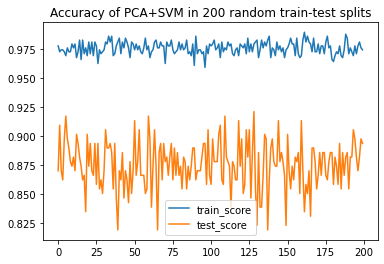

In [69]:
plt.figure()
result_df.plot()
plt.legend(loc="best")
plt.title("Accuracy of PCA+SVM in 200 random train-test splits")
# plt.savefig("results/pca_svm_cv_acc_0707.png")